In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'BaselineModel'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class BaselineModel(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(25, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = BaselineModel().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 3777


In [13]:
# Train model
model, history = sf.train_model(
    model=model,
    device=device,

    # Define training parameters
    epochs=5,
    patience=3,

    # Define dataloaders
    dataloader_train=DataLoader(subsets['train'], batch_size=64, shuffle=True, num_workers=8, pin_memory=True),
    dataloader_val=DataLoader(subsets['val'], batch_size=64, shuffle=True, num_workers=8, pin_memory=True),

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=optim.Adam(params=model.parameters(), lr=0.01),

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

Epoch 1/5: RMSE_train: 1,313,543, RMSE_val: 1,347,252
Epoch 2/5: RMSE_train: 879,495, RMSE_val: 1,150,666
Epoch 3/5: RMSE_train: 814,681, RMSE_val: 1,035,337
Epoch 4/5: RMSE_train: 791,963, RMSE_val: 989,114
Epoch 5/5: RMSE_train: 783,840, RMSE_val: 971,721


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   777051.657  456602.564  0.640  0.613
val     971645.054  525978.300  0.739  0.384
test    934630.748  528936.320  0.694  0.436
--------------------------------------------
total   831732.205  478005.939  0.661  0.555


AttributeError: 'DataFrame' object has no attribute 'loss_train'

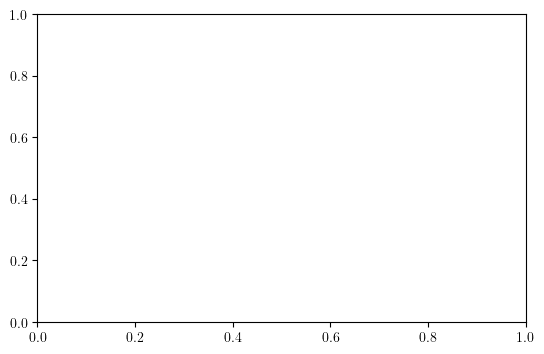

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

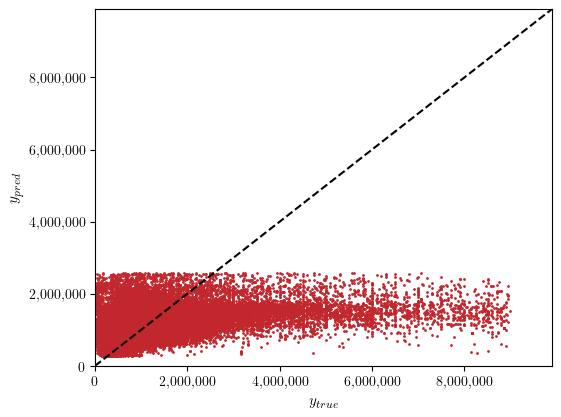

In [ ]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/scatter.pdf')

/Users/jonas/Library/CloudStorage/OneDrive-Personal/02_Education/02_Bachelor_Business-Administration/Bachelors-Thesis/Repository/src/shared_functions.py:745: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(y_min - 0.1 * (y_max - y_min), y_max + 0.1 * (y_max - y_min))


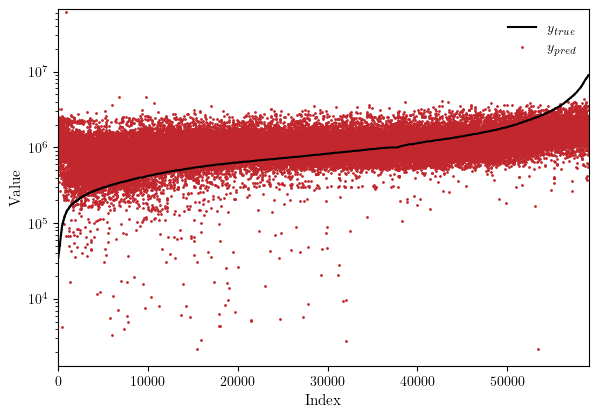

In [ ]:
sf.plot_output_sorted_by_actuals(predictions, save_as=f'../models/{model_name}/log.pdf')